In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: RespiratorySupportRequired or not

In [12]:
df_Vitalsigns_Categorical=pd.read_csv(data_dir+'REACT_Vitalsigns_Categorical'+'.csv')
#df_Vitalsigns_Categorical.info()

In [13]:
#df_Vitalsigns_Categorical.head()

In [14]:
CategorySet=dict()
CategorySet[0]=set(['Air - Not Supported'])
CategorySet[1]=set([
    'Nasal Specs', 'Face Mask', 'Venturi Mask',
    'Non-Rebreath Mask', 'Optiflow / Hi Flow',
    'Trachy Mask'
])
CategorySet[2]=set([
    'NIV - CPAP face mask', 'NIV - CPAP full face mask',
    'NIV - BIPAP face mask', 'NIV - CPAP nasal mask',
    'NIV - BIPAP nasal mask', 'NIV - BIPAP full face mask'
])
CategorySet[3]=set(['Invasive Ventilation'])
CategoryDictionary=dict([(item,label) for label in CategorySet for item in CategorySet[label]])
CategoryDictionary

{'Air - Not Supported': 0,
 'Face Mask': 1,
 'Trachy Mask': 1,
 'Non-Rebreath Mask': 1,
 'Nasal Specs': 1,
 'Venturi Mask': 1,
 'Optiflow / Hi Flow': 1,
 'NIV - CPAP full face mask': 2,
 'NIV - BIPAP face mask': 2,
 'NIV - BIPAP nasal mask': 2,
 'NIV - CPAP face mask': 2,
 'NIV - BIPAP full face mask': 2,
 'NIV - CPAP nasal mask': 2,
 'Invasive Ventilation': 3}

In [15]:
df_label=df_Vitalsigns_Categorical[df_Vitalsigns_Categorical.PARAMETER=='Respiratory Support'][['STUDY_ID','UNITFROM_DATETIME','VALUE']]

In [16]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime,label in df_label.values:
    start_datetime=start_datetime.split('.')[0]#need to be fixed some datetime end with .000
    start_datetime=datetime.strptime(start_datetime,'%Y-%m-%d %H:%M:%S')
    label_category=CategoryDictionary[label]
    if study_id not in label_studyid_time_dic:
        label_studyid_time_dic[study_id]=[start_datetime,label_category]
    else:
        curr_start_datetime,curr_label_category=label_studyid_time_dic[study_id]
        if label_category>curr_label_category or (label_category==curr_label_category and curr_start_datetime>start_datetime):
            label_studyid_time_dic[study_id]=[start_datetime,label_category]

#label_studyid_time_dic

In [17]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime,label_category=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=label_category

labresults

In [18]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [19]:
#df_labresults.head()

In [20]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [21]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [22]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [23]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [24]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [25]:
X_cols=[]

In [26]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [27]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [28]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [29]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(balance_ratio if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)
#XY_missing_value_balanced

fill in nan

In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value)

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models={
    "Logit":LogisticRegression(solver="lbfgs"),
    "MLP":MLPClassifier(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeClassifier(),
    "RandomForest":RandomForestClassifier(n_estimators=100),
    "AdaBoost":AdaBoostClassifier(n_estimators=100),
    "GradientBoost":GradientBoostingClassifier(n_estimators=100),
    "XGBoost":XGBClassifier(n_estimators=100)
}

In [32]:
from sklearn.model_selection import KFold

from sklearn.metrics import average_precision_score

ap_result_lst=[]

kf = KFold(n_splits=10,shuffle=True)

n_class=4

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Y_test = np.zeros([len(y_test),n_class])
    for i in range(len(y_test)):
        Y_test[i,y_test[i]]=1
    ap_result_lst.append(
        [average_precision_score(Y_test,models[model_name].fit(X_train,y_train).predict_proba(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.386615  0.259007      0.256551      0.407257  0.513319       0.508230   
1  0.443461  0.491736      0.344564      0.522974  0.440513       0.490384   
2  0.371425  0.309320      0.267072      0.443655  0.381435       0.398471   
3  0.361190  0.304257      0.249804      0.294671  0.379408       0.336168   
4  0.357750  0.378996      0.300625      0.416098  0.354096       0.325226   
5  0.435906  0.372627      0.279560      0.374808  0.363906       0.406352   
6  0.463129  0.416946      0.284251      0.422871  0.438692       0.491014   
7  0.443092  0.416617      0.291714      0.377647  0.312009       0.418126   
8  0.420610  0.391605      0.251553      0.404634  0.361155       0.335593   
9  0.428131  0.424836      0.290651      0.428798  0.432143       0.450999   

    XGBoost  
0  0.454618  
1  0.416236  
2  0.475609  
3  0.321620  
4  0.373096  
5  0.415741  
6  0.492818  
7  0.411521  
8  0.357329  
9

In [33]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.411131  0.376595      0.281635      0.409341  0.397668       0.416056   

    XGBoost  
0  0.415518  


In [34]:
class_names=[
    'No respiratory support required',
    'Respiratory support required, oxygen only',
    'Respiratory support required, non-invasive ventilation',
    'Respiratory support required, invasive ventilation'
]

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs").fit(X, Y)

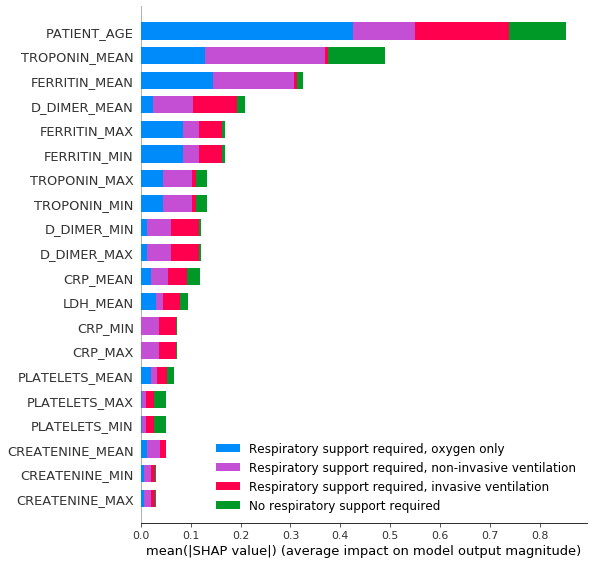

In [36]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(clf,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, Y)

In [38]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.261029535266386
HYPERTENSION : 0.035413794945774686
NEURAL_D : 0.03232990940254479
DIABETES : 0.031471451451393656
OBESITY : 0.030975002490955496
CARDIAC_D : 0.03004092359803955
SMOKING_HISTORY_NR|NR : 0.027568708078504128
ASTHMA : 0.024210799365185807
GENDER_2 : 0.02305020706083537
COPD : 0.022923352841156142
GENDER_1 : 0.022681726137986694
RENAL_D : 0.02263931524045414
MAGLINANT_NEO : 0.02162903240569222
SMOKING_HISTORY_Never smoked|NR : 0.02021701147962901
GLUCOSE_MAX : 0.01853955518517372
GLUCOSE_MIN : 0.017909690965808172
ETHNIC_GROUP_A : 0.017533145404936258
SMOKING_HISTORY_Ex-smoker|NR : 0.017457351946703524
GLUCOSE_MEAN : 0.016938091690760153
RHEUMATO_D : 0.015315969457052488


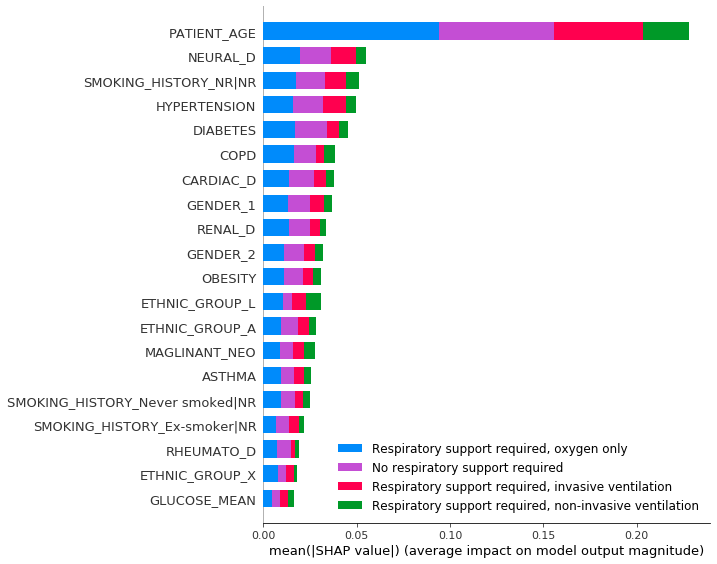

In [39]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X, Y)

In [41]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.37541551805366885
GLUCOSE_MEAN : 0.048518884156818404
NEURAL_D : 0.02752659151496594
CRP_MEAN : 0.02238000132855018
ETHNIC_GROUP_X : 0.019494023691330433
ETHNIC_GROUP_L : 0.015721741158833857
HIV : 0.01535566858318528
ETHNIC_GROUP_S : 0.015017773649880307
NEUTROPHILS_MEAN : 0.014634531809834681
UREA_MIN : 0.014633799665081377
SODIUM_MIN : 0.013528775330289632
ETHNIC_GROUP_N : 0.01274572745508378
ETHNIC_GROUP_A : 0.012742454694210145
PLATELETS_MEAN : 0.012553792634426957
GLUCOSE_MAX : 0.012191908911923023
RHEUMATO_D : 0.012167728095692623
GLUCOSE_MIN : 0.011872641293977039
SMOKING_HISTORY_NR|NR : 0.011709301359432277
DIABETES : 0.011557430759596454
ETHNIC_GROUP_J : 0.011104836847596456


In [42]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100).fit(X, Y)

In [43]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

TRIGYCERIN_MEAN : 0.074188694
FERRITIN_MIN : 0.052852906
UREA_MIN : 0.04243293
HIV : 0.035344843
CRP_MIN : 0.028738568
HB_MEAN : 0.027156724
CRP_MEAN : 0.024950009
SODIUM_MIN : 0.024657136
ETHNIC_GROUP_J : 0.024011618
LDH_MIN : 0.022942571
ALT_MEAN : 0.022369152
PLATELETS_MEAN : 0.02156399
CREATENINE_MEAN : 0.02096545
HB_MIN : 0.02081139
ALT_MIN : 0.02052767
THROMBOEMBOLIC : 0.02000078
BILIRUBIN_MEAN : 0.018833524
ETHNIC_GROUP_X : 0.016675044
IMMUNO : 0.015214023
CREATENINE_MIN : 0.0151292235
